1. Implementação de rede Feedforward para segmentação do batimento cardiaco.

Neste projecto temos como dataset, um conjunto de dados sonoros (batimentos cardiacos). Cada ficheiro numpy contem dois arrays (canais) 1D. O primeiro canal tem o sinal sonora registado através da ocultação e o segundo canal tem a respectiva fase cardiaca (S,sistole,S2,DIastole), ou seja, é o label. 
O desafio desta implementação é utilizar este dataset por forma a treinar uma rede neronal densa para segmentação de um sinal sonoro recolhido.
Assim, numa primeira fase 1.1 carregarei os dados e de seguida farei as tranformações necessárias para formatar o sinal que será o input da rede neuronal densa.

- 1.1 Carregar Dados
Os dados estão em formato numpy array 2 canais, 1D. 
 . Utilizar glob para iterar sobre os ficheiros de um determinado directorio (dados para o exrcicio em formato .npy)

In [1]:
import glob,random
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns 
from keras import layers
from keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.models import Sequential,load_model,Model
from tensorflow.keras.layers import BatchNormalization,Dense,Activation,Conv1D,Input, TimeDistributed,Softmax,LSTM,GRU
from tensorflow.keras.layers import MaxPooling2D, Flatten, Dropout, Reshape,MaxPooling1D,UpSampling1D,Bidirectional


#carrega dados
def get_names(dir):
    '''esta função recebe o directorio e retorna o nome dos ficheiros 
     numa lista e um tensor'''
    list_npy_files = glob.glob(dir + '*.npy')
    fnames_dataset = tf.data.Dataset.from_tensor_slices(list_npy_files)
    return fnames_dataset,list_npy_files

train_names,listat=get_names('trainAlunos/')
valid_names,listav=get_names('validacaoAlunos/')
test_names,listatest=get_names('testeAlunos/')

def read_npy(fname):
    '''esta função recebe o nome de um ficehiro numpy
    e faz o carregamento desse ficheiro convertendo os seus valores em float'''
    fname = fname.decode()
    recData = np.load(fname)
    return recData.astype(np.float32)

# obter dataset com recurso ao map em formato tf 2 canais 
dataset_train = train_names.map(lambda x: tf.numpy_function(read_npy, [x], [tf.float32]))
dataset_valid = valid_names.map(lambda x: tf.numpy_function(read_npy, [x], [tf.float32]))
dataset_test = test_names.map(lambda x: tf.numpy_function(read_npy, [x], [tf.float32]))


2023-03-20 10:37:00.936173: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 10:37:01.147738: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-20 10:37:01.147752: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-20 10:37:01.176065: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-20 10:37:01.751454: W tensorflow/stream_executor/platform/de

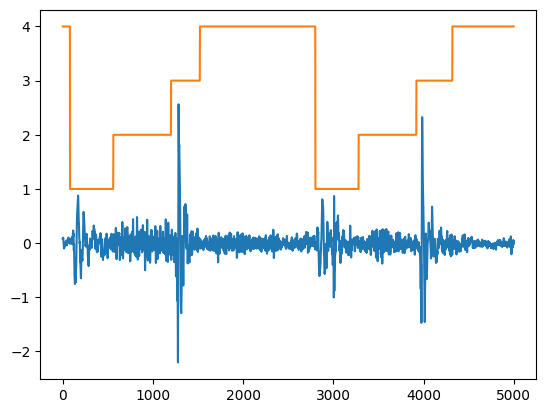

In [2]:
#fazer o plot de um exemplo

it = iter(dataset_valid)
exemplo1 = next(it)
aux=exemplo1[0]

plt.plot(aux[0,:5000]/2000) #reduzir a escala para ficar perceptivel com graficos sobrepostos
plt.plot(aux[1,:5000])

- 1.2 Aplicar Tranformada de Fourrier Short Time

O sinal do dataset está representado no domínio do amplitudetempo e o tamanho dos exemplos do dataset é de cumprimento variavel, portanto numa primeira fase - 1.2.1 definirei o tamanho L = 2500  para todos eles terem a mesma dimensão e de seguida é retirado de cada ficheiro um pedaço de tamanho L de forma aleatória. 
Em 1.2.2 aplicarei a STFT pra converter o sinal para o dominio da frequencia. Para esta transformação recorrerei à função tf.signal.stft que divide o sinal em janelas e executa uma transformação Fourier em cada janela, preservando assim algumas algumas informações de tempo.

tf.Tensor([2. 2. 2. ... 2. 2. 2.], shape=(2500,), dtype=float32)


<function matplotlib.pyplot.show(close=None, block=None)>

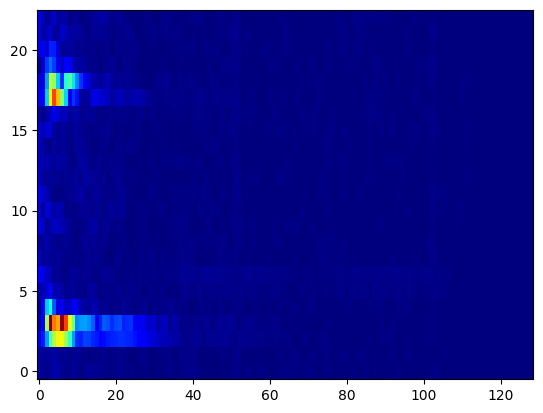

In [3]:
# 1.2.1 Cortar os dados em arrays de comprimento predefinido (definirei 2500)
def func_util(x):
    N=tf.shape(x)[1]
    random=tf.random.uniform([],maxval=N-2500,dtype=tf.dtypes.int32)
    return x[:,random:random+2500]

def cut_dataset(dataset):
    #Cut in arrays with lenght L
    data_cut = dataset.map(func_util) 
    return data_cut

dataset_train_c=cut_dataset(dataset_train)
dataset_valid_c=cut_dataset(dataset_valid)

# 1.2.2 Aplicar STFT com janelas de 250 e passo 126
dataset_train_ft = dataset_train_c.map(lambda x: (tf.math.abs(tf.signal.stft(signals = x[0], frame_length = 250, frame_step = 100)), x[1]))
dataset_valid_ft = dataset_valid_c.map(lambda x: (tf.math.abs(tf.signal.stft(signals = x[0], frame_length = 250, frame_step = 100)), x[1]))


##### imprimir exemplos
it_ft = iter(dataset_valid_ft)
exemplo_spec= next(it_ft)
print(exemplo_spec[1])
plt.imshow(exemplo_spec[0],origin='lower', cmap='jet', interpolation='nearest', aspect='auto')
plt.show

- plot onda vs espectograma

<ipython-input-5-78793e6e07f8>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


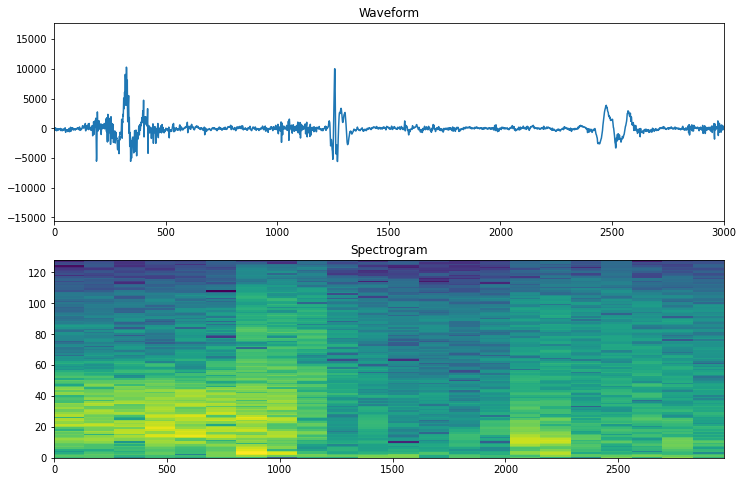

In [5]:
#plot de um exemplo amp/freq vs transformação freq/time

def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(aux[0].shape[0])
axes[0].plot(timescale, aux[0].numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 3000])

plot_spectrogram(exemplo_spec[0].numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

- Produzir Batches para dar como input à rede

De seguida são produzidos Batches de tamanho de 16 treino e 2 para a validação, considerando o dataset cortado com aplicacao da STFT. 

In [4]:
#definir batches
batch_size = 16
# batch treino e validacao 
dataset_input = dataset_train_ft.batch(batch_size)
dataset_input_val=dataset_valid_ft.batch(2)

- Definir e Treinar modelo ML para segmentação de uma entrada sonora 1D

O sinal após aplicada STFT é de tamanho 23*129 (exemplo) e será o input da rede.
Como se trata de um problema de segmentação, todos os elementos do array de antrada (input) da entrada terao que ser classificados e portanto numa primeira fase tentarei que a rede aprenda caracteristicas importantes e de seguida retornarei à dimensão actual (2500 definida anteriormente). 
Assim, para edificar esta Rede Neuronal Densa inicialmente irei fazer um reshape para transformar os input em 1D e de seguida esse input entrerá numa rede densa de 3 camadas com 500,100,20 resepctivamente com activações relu para evitar vanishment gradients e com dropout para tentar evitar overfiting, no final da rede será uma camada de 12500 neuronios, que será tranformada (através do reshape) em (2500,5) o que corresponde aos 5 labels possíveis (o zero existe devido a extends), cada que será activada através do softmax, que nos dá a probabilidade de cada elemento pertencer a uma determinada classe [0-5].
A rede será compilada com o optimizador adam, com loss 'sparse categorical entropy' e metrica 'accuracy' para sparse categorical (tf.keras.metrics.SparseCategoricalAccuracy()). 


In [12]:
# defenição modelo
def model_ann():
    '''esta função edifica o modelo'''
    model=Sequential()
    model.add(Flatten(input_shape=(23,129)))#reshape data to 1d 
    model.add(Dense(500,activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(100,activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(20,activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(12500))
    model.add(Reshape((2500,5)))
    model.add(Activation('softmax'))
    return model

#checkpoint = ModelCheckpoint('model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto') 
model_mlseg=model_ann() #criar modelo
model_mlseg.summary() #descricao/arquitectura do modelo
opt = keras.optimizers.Adam(learning_rate=0.001)
model_mlseg.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=tf.keras.metrics.SparseCategoricalAccuracy())
history=model_mlseg.fit(dataset_input, validation_data=dataset_input_val,epochs=75) #,callbacks=[checkpoint]

model_mlseg.save_weights('cnn_seg.h5', overwrite=True, save_format=None, options=None)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 2967)              0         
                                                                 
 dense_8 (Dense)             (None, 500)               1484000   
                                                                 
 batch_normalization_4 (Batc  (None, 500)              2000      
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 500)               0         
                                                                 
 dense_9 (Dense)             (None, 100)               50100     
                                                                 
 batch_normalization_5 (Batc  (None, 100)              400       
 hNormalization)                                      

Epoch 35/75
157/157 [==============================] - 2s 13ms/step - loss: 0.7134 - sparse_categorical_accuracy: 0.7194 - val_loss: 0.6783 - val_sparse_categorical_accuracy: 0.7757
Epoch 36/75
157/157 [==============================] - 2s 13ms/step - loss: 0.7151 - sparse_categorical_accuracy: 0.7140 - val_loss: 0.6921 - val_sparse_categorical_accuracy: 0.7565
Epoch 37/75
157/157 [==============================] - 2s 14ms/step - loss: 0.7197 - sparse_categorical_accuracy: 0.7191 - val_loss: 0.6715 - val_sparse_categorical_accuracy: 0.7683
Epoch 38/75
157/157 [==============================] - 2s 14ms/step - loss: 0.7407 - sparse_categorical_accuracy: 0.7064 - val_loss: 0.6565 - val_sparse_categorical_accuracy: 0.7729
Epoch 39/75
157/157 [==============================] - 3s 16ms/step - loss: 0.7245 - sparse_categorical_accuracy: 0.7149 - val_loss: 0.6863 - val_sparse_categorical_accuracy: 0.7472
Epoch 40/75
157/157 [==============================] - 2s 15ms/step - loss: 0.7146 - spars

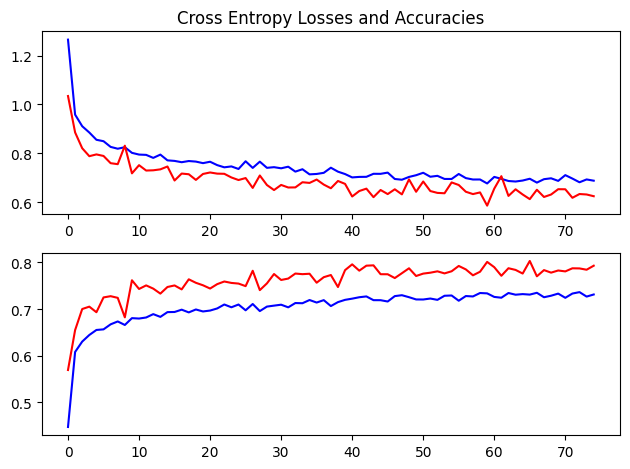

In [14]:

# plot diagnostico 
def avaliacao(history,epochs):
    ''' esta função recebe os dados recolhidos no treino e as epochs para limentar o eixo x
    de segida são feitos 2 subplot, com a loss e a accuracy, respetivamente, de treino e teste'''
    epochs_array=np.arange(epochs)
    # plot loss
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Losses and Accuracies')
    plt.plot(epochs_array,history.history['loss'], color='blue', label='train')
    plt.plot(epochs_array,history.history['val_loss'], color='red', label='test')
    
    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.plot(epochs_array,history.history['sparse_categorical_accuracy'], color='blue', label='train')
    plt.plot(epochs_array,history.history['val_sparse_categorical_accuracy'], color='red', label='test')
    plt.tight_layout()
    plt.show()

avaliacao(history,75)

- Edificar e treinar modelo recorrendo ao upsampling 
Este modelo tem a mesma arquitectura que o anterior, contudo utilizei o upsampling para obter a dimensão da camada final = à dimensão dos exemplos (2500). Neste caso utilizou-se um upsampling = 100 para obter uma camada de saída =12500, pois a ultimo camada densa tem 125 neuronios (com reshape para 25,5) correspondentes a cada uma das classses. O modelo foi treinado em 50 épocas e os melhores pesos considerando o dataset de validação foram guardados.  

In [15]:
def model_ann_up():
    '''esta função edifica o modelo'''
    model=Sequential()
    model.add(Flatten(input_shape=(23,129)))#reshape data to 1d 
    model.add(Dense(500,activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(100,activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(20,activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(125))
    model.add(Reshape((25, 5)))
    model.add(Activation('softmax'))
    #Adicionar upsampling por forma a obter um output de saida igual ao de entrada, devidamente segmentado
    model.add(UpSampling1D(100)) #escolhido um upsampling de 10
    return model

model1_up=model_ann_up() #criar modelo
model1_up.summary() #descricao/arquitectura do modelo
opt = keras.optimizers.Adam(learning_rate=0.005)
model1_up.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=tf.keras.metrics.SparseCategoricalAccuracy())
history_up=model1_up.fit(dataset_input, validation_data=dataset_input_val, epochs=75)
model1_up.save_weights('nnup_seg.h5', overwrite=True, save_format=None, options=None)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 2967)              0         
                                                                 
 dense_12 (Dense)            (None, 500)               1484000   
                                                                 
 batch_normalization_6 (Batc  (None, 500)              2000      
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 500)               0         
                                                                 
 dense_13 (Dense)            (None, 100)               50100     
                                                                 
 batch_normalization_7 (Batc  (None, 100)              400       
 hNormalization)                                      

Epoch 34/75
157/157 [==============================] - 2s 14ms/step - loss: 0.7757 - sparse_categorical_accuracy: 0.6994 - val_loss: 0.7161 - val_sparse_categorical_accuracy: 0.7422
Epoch 35/75
157/157 [==============================] - 2s 14ms/step - loss: 0.7792 - sparse_categorical_accuracy: 0.6950 - val_loss: 0.7299 - val_sparse_categorical_accuracy: 0.7602
Epoch 36/75
157/157 [==============================] - 2s 14ms/step - loss: 0.7598 - sparse_categorical_accuracy: 0.7021 - val_loss: 0.7538 - val_sparse_categorical_accuracy: 0.7609
Epoch 37/75
157/157 [==============================] - 2s 14ms/step - loss: 0.7702 - sparse_categorical_accuracy: 0.6962 - val_loss: 0.6994 - val_sparse_categorical_accuracy: 0.7438
Epoch 38/75
157/157 [==============================] - 2s 14ms/step - loss: 0.7626 - sparse_categorical_accuracy: 0.7033 - val_loss: 0.6919 - val_sparse_categorical_accuracy: 0.7589
Epoch 39/75
157/157 [==============================] - 2s 14ms/step - loss: 0.7741 - spars

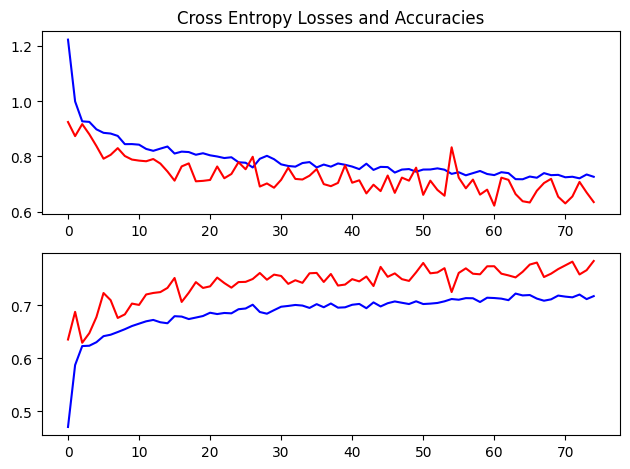

In [16]:
# diagnostico modelo com upsampling
avaliacao(history_up,75)

- Plot de um exemplo e Avaliação do Modelo
O modelo foi avaliado no TestSet.
Inicialmente fiz o plot de um exemplo escolhido de forma aleatoria. Para tal recorri ao método random.choice sobre a lista dos nomes do ficheiros. 
Após escolhido, os ficheiros foram cortados em parcelas de 2500 (tamanho input definido para a rede). Como os input são de tamanhos variados foram acrecentados os zeros necessários para uqe os dataset tenham um tamanho multiplo de 2500 (que é definido pela equacao: Tamanho do exemplo + ( tamanho requerido - resto da divisao N/2500) ou N+(2500-N%2500)). De seguida iterei com step de 2500 sobre o exemplo expandido com zeros, por forma a criar as parcelas de tamanho 2500. As parcelas sujeitas a uma tranformação de forrier ST com janela 250 e passo 100 (representa uma sobreposição de 60%). As parcelas foram colocadas num array 2D por forma a serem fornecidas com input.
O exemplo foi preprocessado e através do método predict foi obtida a sua segmentação. O output será do tipo (numero de parcelas,2500 tamanho de cada parcela,5 labels). A este output serão retirados os labels referentes aos zeros previamente acrecentado e depois serão colados todas as restante parcelas. 

In [17]:
# carregar ficheir0, fazer cortes de tamanho 2500 (aacrescentar zeros). retorna array shape (numero pedaços,L,nº clases)

#escolher de forma aleatoria nome do ficheira na pasta teste
path=random.choice(listatest) 
def descarregar(path_name):
    '''esta funcao recebe o caminho dos ficheiros e retorna o array numpy'''
    return np.load(path_name).astype(np.float32)
file_ex=descarregar(path)    

def cut_equal(file):
    '''esta função recebe ficheiro e recorta em partes iguais a 2500 acrecentando 0 ao ultimo pedaço
    retorna as suas  STFT'''
    N=len(file[0])
    x=N%2500
    expand=N+(2500-x)
    array_expanded=np.concatenate([file[0],np.zeros(expand-N)])
    control=0
    STFT=[]
    for i in range(2500,len(array_expanded)+1,2500):
        STFT.append((tf.math.abs(tf.signal.stft(signals = array_expanded[control:i], frame_length = 250, frame_step = 100))))
        control=i
    return np.array(STFT),file[1]

exemplo_teste,exemplo_label=cut_equal(file_ex)   


- Eliminar labels correspondentes aos zeros e calcular loss e accuracy considerando todo o exemplo.
Como o metodo predict retorna os labels para cada exemplo ainda em formato probabilidade defini uma função loss_accuracy que formata o output no formato pretendido e retorna a loss e accuracy para aquele exemplo.
inicialmente tranformo o output 2d obtido atraves do medo predict() em 1 d. De seguida verifico o tamanho do output com o tamanho do exemplo antes de acrecentar os zeros, por forma a retirar o excedente. Após verificar a condição calculo a loss através da função losses.SparseCategoricalCrossentropy() e a accuracy calculo a partir da fração entre numero de classificacoes com sucesso e numero total(lenght).
De seguida faço o plot de um exemplo com as respectivas segementações, verdadedira e estimada.

1/1 [==============================] - 0s 15ms/step
loss: 0.4753131568431854, accuracy:0.8505882082095909


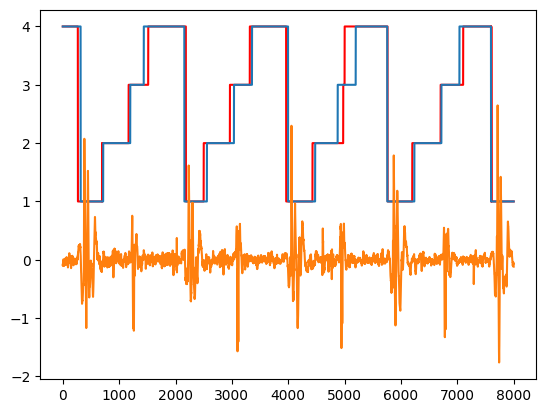

In [18]:
# calcular loss apos eliminar targets a mais
def loss_accuracy(preds,true_preds):
    pred=preds.reshape(-1,5)
    scce = tf.keras.losses.SparseCategoricalCrossentropy()
    predicted=[]
    if pred.shape[0]==len(true_preds):
        loss=scce(true_preds, pred).numpy()
        accuracy = np.sum(np.argmax(pred,axis=-1)== true_preds)/len(true_preds)
        predicted=pred
    else:
        pred_cut=np.delete(pred,slice(len(true_preds),pred.shape[0]),0)
        loss=scce(true_preds, pred_cut).numpy()
        accuracy = np.sum(np.argmax(pred_cut,axis=-1)== true_preds)/len(true_preds)
        predicted=pred
    return predicted,loss,accuracy
        
predict=model_mlseg.predict(exemplo_teste)   
predicted,loss_ex,acc=loss_accuracy(predict,exemplo_label)   



def plot_predictions(exemplo,prediction,true_label):
    '''esta funcao recebe imagens aleatorias do data set teste e retorna 
    as imagens com o label verdadeirro T e o previsto P'''
    plt.plot(np.argmax(prediction,axis=-1)[:8000],color='r')
    plt.plot(true_label[:8000])
    plt.plot(exemplo[:8000]/2500)
    
plot_predictions(file_ex[0],predicted,exemplo_label)

print(f'loss: {loss_ex}, accuracy:{acc}')  
    

- Avaliar o modelo para todos os exemplos do test set

Para avaliar o modelo para todos os exemplos iterei sobre a lista de nomes do directorio e recorrendo às funções anteriores calculei a média e a accuracy para todos eles, fazendo de seguida a média. 
A loss e accuracy do modelo no dataset test são 0.70 e 0.77, respectivamente.

In [19]:
losses_history,accuracy_history=[],[]
for i in listatest: #iterar sobre exeplos do test set
    file_e=descarregar(i)
    exemplo_stft,label_true=cut_equal(file_e)
    predict_it=model_mlseg.predict(exemplo_stft)
    predicted,loss_ann,acc_ann=loss_accuracy(predict_it,label_true) 
    losses_history.append(loss_ann)
    accuracy_history.append(acc_ann)

model1_up_loss=sum(losses_history) / len(losses_history)
model1_up_acc=sum(accuracy_history) / len(accuracy_history)
print(f'model loss: {model1_up_loss}, model accuracy:{model1_up_acc}')  

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step
model loss: 0.6817186127280022, model accuracy:0.7721848544206925


2. Implementação de rede CNN para segmentação do batimento cardiaco.

O desafio desta implementação é utilizar este dataset por forma a treinar uma rede neuronal conv para segmentação de um sinal sonoro de tamanho fixo.

In [21]:
# defenição modelo
def model_cnn1():
    '''esta função edifica o modelo'''
    model = Sequential() #modelo sequencial
    model.add(Conv1D(64, 9, padding="same",input_shape=(23,129))) 
    model.add(Activation("relu")) 
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size = (4), strides=(4),data_format='channels_first'))
    model.add(Dropout(0.2))
    model.add(Conv1D(32, 6, padding="same")) 
    model.add(Activation("relu")) 
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size = (4), strides=(4),data_format='channels_first'))
    model.add(Dropout(0.2))
    model.add(Conv1D(32, 3, padding="same"))
    model.add(Dropout(0.1))
    model.add(Activation("relu")) 
    model.add(BatchNormalization())    
    model.add(MaxPooling1D(pool_size = (4), strides=(4),data_format='channels_first'))
    model.add(Flatten())
    #output layer
    model.add(Dense(1250)) 
    model.add(Reshape((250, 5)))
    model.add(Activation("softmax"))
    #upsampling para recuperar o tamanho original
    model.add(UpSampling1D(10))
    return model

# preparar par gravar melhores pesos
filepath1="cnn_weights.h5"
checkpoint = ModelCheckpoint(filepath1, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True,save_weights_only=True,  mode='max')
callbacks_list = [checkpoint]

model2_1d=model_cnn1() #criar modelo
model2_1d.summary() #descricao/arquitectura do modelo
model2_1d.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=tf.keras.metrics.SparseCategoricalAccuracy())
history_cnn=model2_1d.fit(dataset_input, validation_data=dataset_input_val, epochs=75,callbacks=callbacks_list)
model2_1d.save_weights('cnn_fix.h5', overwrite=True, save_format=None, options=None)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 23, 64)            74368     
                                                                 
 activation_8 (Activation)   (None, 23, 64)            0         
                                                                 
 batch_normalization_11 (Bat  (None, 23, 64)           256       
 chNormalization)                                                
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 23, 16)           0         
 1D)                                                             
                                                                 
 dropout_11 (Dropout)        (None, 23, 16)            0         
                                                                 
 conv1d_4 (Conv1D)           (None, 23, 32)           

152/157 [============================>.] - ETA: 0s - loss: 0.4990 - sparse_categorical_accuracy: 0.8142
Epoch 13: val_sparse_categorical_accuracy did not improve from 0.81891
157/157 [==============================] - 2s 12ms/step - loss: 0.4951 - sparse_categorical_accuracy: 0.8159 - val_loss: 0.5326 - val_sparse_categorical_accuracy: 0.8080
Epoch 14/75
156/157 [============================>.] - ETA: 0s - loss: 0.4835 - sparse_categorical_accuracy: 0.8225
Epoch 14: val_sparse_categorical_accuracy improved from 0.81891 to 0.82004, saving model to cnn_weights.h5
157/157 [==============================] - 3s 20ms/step - loss: 0.4838 - sparse_categorical_accuracy: 0.8223 - val_loss: 0.4782 - val_sparse_categorical_accuracy: 0.8200
Epoch 15/75
156/157 [============================>.] - ETA: 0s - loss: 0.5009 - sparse_categorical_accuracy: 0.8121
Epoch 15: val_sparse_categorical_accuracy did not improve from 0.82004
157/157 [==============================] - 2s 12ms/step - loss: 0.5009 - sp

Epoch 36/75
153/157 [============================>.] - ETA: 0s - loss: 0.4537 - sparse_categorical_accuracy: 0.8283
Epoch 36: val_sparse_categorical_accuracy did not improve from 0.84083
157/157 [==============================] - 2s 12ms/step - loss: 0.4522 - sparse_categorical_accuracy: 0.8288 - val_loss: 0.4898 - val_sparse_categorical_accuracy: 0.8143
Epoch 37/75
156/157 [============================>.] - ETA: 0s - loss: 0.4594 - sparse_categorical_accuracy: 0.8266
Epoch 37: val_sparse_categorical_accuracy did not improve from 0.84083
157/157 [==============================] - 2s 12ms/step - loss: 0.4593 - sparse_categorical_accuracy: 0.8266 - val_loss: 0.4626 - val_sparse_categorical_accuracy: 0.8334
Epoch 38/75
154/157 [============================>.] - ETA: 0s - loss: 0.4429 - sparse_categorical_accuracy: 0.8339
Epoch 38: val_sparse_categorical_accuracy did not improve from 0.84083
157/157 [==============================] - 2s 12ms/step - loss: 0.4425 - sparse_categorical_accurac

Epoch 59/75
155/157 [============================>.] - ETA: 0s - loss: 0.4414 - sparse_categorical_accuracy: 0.8329
Epoch 59: val_sparse_categorical_accuracy did not improve from 0.84655
157/157 [==============================] - 3s 17ms/step - loss: 0.4408 - sparse_categorical_accuracy: 0.8331 - val_loss: 0.4767 - val_sparse_categorical_accuracy: 0.8285
Epoch 60/75
153/157 [============================>.] - ETA: 0s - loss: 0.4252 - sparse_categorical_accuracy: 0.8383
Epoch 60: val_sparse_categorical_accuracy did not improve from 0.84655
157/157 [==============================] - 2s 11ms/step - loss: 0.4250 - sparse_categorical_accuracy: 0.8385 - val_loss: 0.4464 - val_sparse_categorical_accuracy: 0.8386
Epoch 61/75
153/157 [============================>.] - ETA: 0s - loss: 0.4343 - sparse_categorical_accuracy: 0.8354
Epoch 61: val_sparse_categorical_accuracy did not improve from 0.84655
157/157 [==============================] - 2s 11ms/step - loss: 0.4337 - sparse_categorical_accurac

- diagnostico do modelo

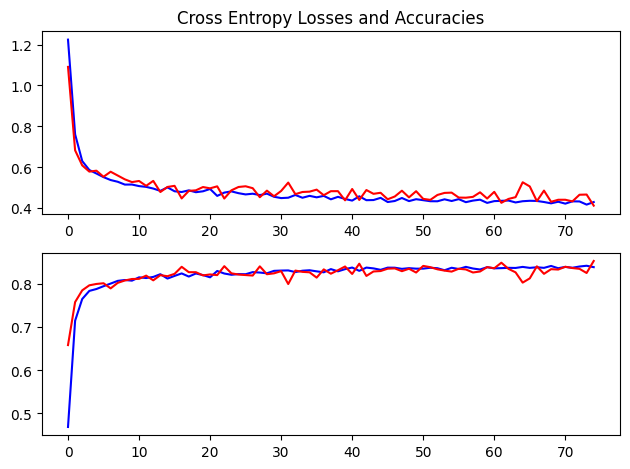

In [22]:
avaliacao(history_cnn,75)

- Verificar vizualmente performance do modelo em exemplo aleatorio

1/1 [==============================] - 0s 164ms/step
loss: 0.20008616149425507, accuracy:0.925593388125331


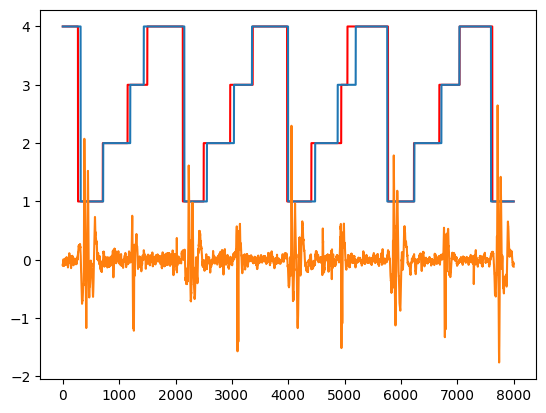

In [23]:
#file_ex

model2_1d.load_weights(filepath1)
predict_cnn=model2_1d.predict(exemplo_teste)
predicted_cnn,loss_ex_cnn,acc_ex_cnn=loss_accuracy(predict_cnn,exemplo_label) 
plot_predictions(file_ex[0],predicted_cnn,exemplo_label)

print(f'loss: {loss_ex_cnn}, accuracy:{acc_ex_cnn}')  

2.1  Implementação de rede CNN para segmentação do batimento cardiaco.

O desafio desta implementação é utilizar este dataset por forma a treinar uma rede neronal convulucional para segmentação de um sinal sonoro de tamanho variado.

In [24]:
# Preparar input dataset por forma a dar entrada no modelo funcional (tamanho do sinal,sinal tranformado,label)

dataset_train_var = dataset_train.map(lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(signals = x[0], frame_length = 250, frame_step = 100))), x[1])) #length, signal after transform, label
dataset_val_var = dataset_valid.map(lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(signals = x[0], frame_length = 250, frame_step = 100))), x[1])) #length, signal after transform, label
dataset_test_var = dataset_test.map(lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(signals = x[0], frame_length = 250, frame_step = 100))), x[1])) #length, signal after transform, label
# produzir batches 
L = 129 
input_var= dataset_train_var.padded_batch(16, padded_shapes = (([], tf.TensorShape([None, L])), [None]))
input_val_var= dataset_val_var.padded_batch(8, padded_shapes = (([], tf.TensorShape([None, L])), [None]))
input_test_var= dataset_test_var.padded_batch(1, padded_shapes = (([], tf.TensorShape([None, L])), [None]))

In [25]:
def model_cnn_var():
    '''esta funcao recebe um input variavel e retorna a sua segmentacao'''
    inputs = Input(shape=(None,129),name='inputs')
    inputs_lenght = Input(shape=[],name='inputs_lenght')
    
    layer = Conv1D(128, 6, padding="same")(inputs)
    layer = Activation("relu")(layer)
    layer = Dropout(0.3) (layer)
    layer = BatchNormalization(axis=-1)(layer)
    layer = MaxPooling1D(pool_size= 2)(layer)
    
    layer = Conv1D(64, 6, padding="same")(layer)
    layer = Activation("relu")(layer)
    layer = BatchNormalization(axis=-1)(layer)
    layer = Dropout(0.5)(layer)
    
    layer = Conv1D(64, 4, padding="same")(layer)
    layer = Activation("relu")(layer)
    layer = BatchNormalization(axis=-1)(layer)
    layer = MaxPooling1D(pool_size= 3)(layer)
    layer = Dropout(0.35)(layer)

    layer = Conv1D(32, 6, padding="same")(layer)
    layer = Activation("relu")(layer)
    #layer = MaxPooling1D(pool_size= 3)(layer)
    layer = BatchNormalization(axis=-1)(layer)
    layer = Dropout(0.45)(layer)

    layer = Conv1D(32, 4, padding="same")(layer)
    layer = Activation("relu")(layer)
    layer = MaxPooling1D(pool_size= 3)(layer)
    layer = BatchNormalization(axis=-1)(layer)
    layer = Dropout(0.55)(layer)
    
    layer = Conv1D(32, 6, padding="same")(layer)
    layer = Activation("relu")(layer)
    layer = BatchNormalization(axis=-1)(layer)
    layer = Dropout(0.35)(layer)
    
    layer = TimeDistributed(Dense(5000))(layer)
    layer = Reshape((-1,5))(layer)
    layer = Activation("softmax")(layer)
    layer = UpSampling1D(size=10)(layer)
    lenght= tf.cast(tf.reduce_max(inputs_lenght), tf.int32)
    output = layer[:,:lenght]
    #outputsoft = Activation("softmax")(output)
    model = Model(inputs = (inputs_lenght,inputs) , outputs=output)
    model.summary()
    return model


# preparar par gravar melhores pesos
filepath2="cnnvar_weights1.h5"
checkpoint = ModelCheckpoint(filepath2, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True,save_weights_only=True,  mode='max')
callbacks_list = [checkpoint]

modelcnn_var=model_cnn_var() #criar modelo

opt = keras.optimizers.Adam(learning_rate=0.004)
modelcnn_var.compile(loss="sparse_categorical_crossentropy", optimizer=opt,metrics=["sparse_categorical_accuracy"])
history_cnn_var= modelcnn_var.fit(input_var,validation_data=input_val_var,shuffle=True, epochs=500,verbose=1,callbacks=callbacks_list)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None, 129)]  0           []                               
                                                                                                  
 conv1d_6 (Conv1D)              (None, None, 128)    99200       ['inputs[0][0]']                 
                                                                                                  
 activation_12 (Activation)     (None, None, 128)    0           ['conv1d_6[0][0]']               
                                                                                                  
 dropout_14 (Dropout)           (None, None, 128)    0           ['activation_12[0][0]']          
                                                                                              

                                                                                                  
Total params: 353,896
Trainable params: 353,192
Non-trainable params: 704
__________________________________________________________________________________________________
Epoch 1/500
  1/157 [..............................] - ETA: 2:56 - loss: 1.6218 - sparse_categorical_accuracy: 0.2019

2023-03-20 11:08:15.342305: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 86400000 exceeds 10% of free system memory.
2023-03-20 11:08:15.404244: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 86400000 exceeds 10% of free system memory.
2023-03-20 11:08:15.483510: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 86400000 exceeds 10% of free system memory.


  3/157 [..............................] - ETA: 21s - loss: 1.6205 - sparse_categorical_accuracy: 0.2010

2023-03-20 11:08:15.545638: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 86400000 exceeds 10% of free system memory.
2023-03-20 11:08:15.627566: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 83200000 exceeds 10% of free system memory.


156/157 [============================>.] - ETA: 0s - loss: 1.4436 - sparse_categorical_accuracy: 0.3852
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.44198, saving model to cnnvar_weights1.h5
157/157 [==============================] - 23s 140ms/step - loss: 1.4430 - sparse_categorical_accuracy: 0.3854 - val_loss: 1.3421 - val_sparse_categorical_accuracy: 0.4420
Epoch 2/500
156/157 [============================>.] - ETA: 0s - loss: 1.3548 - sparse_categorical_accuracy: 0.4320
Epoch 2: val_sparse_categorical_accuracy did not improve from 0.44198
157/157 [==============================] - 25s 161ms/step - loss: 1.3543 - sparse_categorical_accuracy: 0.4322 - val_loss: 1.3437 - val_sparse_categorical_accuracy: 0.4402
Epoch 3/500
156/157 [============================>.] - ETA: 0s - loss: 1.3329 - sparse_categorical_accuracy: 0.4406
Epoch 3: val_sparse_categorical_accuracy improved from 0.44198 to 0.44977, saving model to cnnvar_weights1.h5
157/157 [========================

157/157 [==============================] - ETA: 0s - loss: 1.2366 - sparse_categorical_accuracy: 0.4793
Epoch 23: val_sparse_categorical_accuracy did not improve from 0.46314
157/157 [==============================] - 29s 184ms/step - loss: 1.2366 - sparse_categorical_accuracy: 0.4793 - val_loss: 1.3815 - val_sparse_categorical_accuracy: 0.4475
Epoch 24/500
156/157 [============================>.] - ETA: 0s - loss: 1.2389 - sparse_categorical_accuracy: 0.4793
Epoch 24: val_sparse_categorical_accuracy did not improve from 0.46314
157/157 [==============================] - 29s 187ms/step - loss: 1.2383 - sparse_categorical_accuracy: 0.4795 - val_loss: 1.3373 - val_sparse_categorical_accuracy: 0.4554
Epoch 25/500
156/157 [============================>.] - ETA: 0s - loss: 1.2293 - sparse_categorical_accuracy: 0.4805
Epoch 25: val_sparse_categorical_accuracy did not improve from 0.46314
157/157 [==============================] - 32s 202ms/step - loss: 1.2288 - sparse_categorical_accuracy: 0

KeyboardInterrupt: 

- diagnostico do treino
 

In [11]:
avaliacao(history_cnn_var,500)

- Testar modelo em exemplo aleatorio

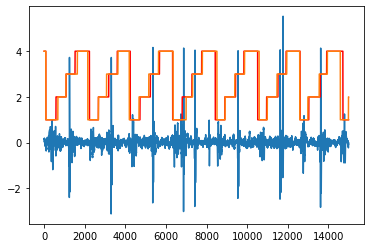

In [49]:
# retirar exemplo do dataset test
modelcnn_var.load_weights('cnnvar_weights1.h5')

signal_test=dataset_test.map(lambda x: x[0])
input_test_ex= dataset_test_var.padded_batch(1, padded_shapes = (([], tf.TensorShape([None, L])), [None]))
it,it2 = iter(input_test_ex),iter(signal_test)
exemplo = next(it)
signal = next(it2)

predict_cnn_var=modelcnn_var.predict((exemplo[0]))
predicted_cnn_var=np.argmax(predict_cnn_var,axis=-1)

scce = tf.keras.losses.SparseCategoricalCrossentropy()
loss_ex_cnn_var=scce(exemplo[1].numpy(), predict_cnn_var).numpy()
acc_ex_cnn_var = np.sum(predicted_cnn_var== exemplo[1].numpy())/exemplo[1].numpy().shape[1]

#plot exemplo aleatorio com segmentacao verdadeira e estimada
plt.plot(signal.numpy()[:15000]/2500)
plt.plot(predicted_cnn_var.flatten()[:15000],color='r')
plt.plot(exemplo[1].numpy().flatten()[:15000])



- Avaliar modelo com dados do True Dataset
Utilizar pesos que maximizaram a validação durante o treino

In [59]:
dataset_test_var = dataset_test.map(lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(signals = x[0], frame_length = 250, frame_step = 100))), x[1])) #length, signal after transform, label
test_var= dataset_test_var.padded_batch(5, padded_shapes = (([], tf.TensorShape([None, L])), [None]))
score=modelcnn_var.evaluate(test_var)


58/58 [==============================] - 4s 76ms/step - loss: 0.7297 - sparse_categorical_accuracy: 0.7076


3. Implementar modelo RNN (recurrent neural network
O modelo RNN é util neste tipo de segmentação, pois o labels das entradas posteriores e anteriores importa e portanto devem ser toamas em consideração.
A RNN implementada é do tipo many-to-many, onde a entrada respeita o tamanho do exemplo após aplicada STFT e a saída é do tamanho do exemplo antes dessa aplicação. O desafio é construir um modelo capaz de segmentar o heartsound de tamanhos variaveís através de uma rede RNN.

In [52]:
def model_RNN():
    '''esta funcao recebe um input variavel e retorna a sua segmentacao, feita recorrendo a uma rnn com duas LSTM apos duac camdas de convuloções'''
    inputs = Input(shape=(None,129),name='inputs')
    T = Input(shape=[],name='T')
    layer = Conv1D(64, 9, padding="same")(inputs)
    layer = Activation("relu")(layer)
    layer = Dropout(0.3) (layer)
    layer = BatchNormalization(axis=-1)(layer)
    layer = MaxPooling1D(pool_size= 3)(layer)
    
    layer = Conv1D(64, 6, padding="same")(layer)
    layer = Activation("relu")(layer)
    layer = BatchNormalization(axis=-1)(layer)
    layer = Dropout(0.5)(layer) 
    
    layer = Bidirectional(LSTM(80,return_sequences=True,dropout=0.3, recurrent_dropout= 0.3))(layer)
    layer = Bidirectional(LSTM(80,return_sequences=True,dropout=0.3, recurrent_dropout= 0.3))(layer)
    layer = TimeDistributed(Dense(2000))(layer)
    layer = Reshape((-1,5))(layer)
    layer = Activation("softmax")(layer)
    layer = UpSampling1D(size=10)(layer)
    lenght= tf.cast(tf.reduce_max(T), tf.int32)
    output = layer[:,:lenght]
    model = Model(inputs = (T,inputs) , outputs=output)
    return model


# preparar par gravar melhores pesos
filepath3="rnn_weightsLIAT.h5"
checkpoint = ModelCheckpoint(filepath3, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True,save_weights_only=True,  mode='max')
callbacks_list = [checkpoint]

modelrnn=model_RNN() #criar modelo
modelrnn.summary()
opt = keras.optimizers.Adam(learning_rate=0.003)
modelrnn.compile(loss="sparse_categorical_crossentropy", optimizer=opt,metrics=["sparse_categorical_accuracy"])
#history_rnn= modelrnn.fit(input_var,validation_data=input_val_var,shuffle=True, epochs=100,verbose=1,callbacks=callbacks_list)


Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None, 129)]  0           []                               
                                                                                                  
 conv1d_50 (Conv1D)             (None, None, 64)     74368       ['inputs[0][0]']                 
                                                                                                  
 activation_69 (Activation)     (None, None, 64)     0           ['conv1d_50[0][0]']              
                                                                                                  
 dropout_203 (Dropout)          (None, None, 64)     0           ['activation_69[0][0]']          
                                                                                           

- diagnostico do treino

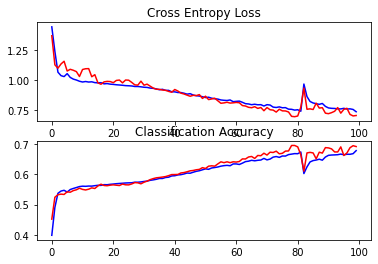

In [31]:
avaliacao(history_rnn,100)

- Segmentar exemplo random
utilizar funcoes previamente definidas

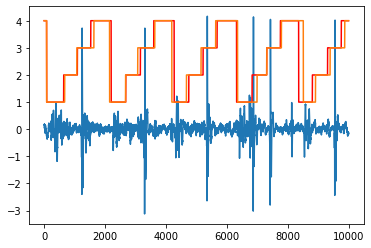

In [53]:
modelrnn.load_weights('rnn_weightsLIAT.h5')
predict_rnn=modelrnn.predict((exemplo[0]))
predicted_rnn=np.argmax(predict_rnn,axis=-1)

scce = tf.keras.losses.SparseCategoricalCrossentropy()
loss_ex_rnn=scce(exemplo[1].numpy(), predict_rnn).numpy()
acc_ex_rnn = np.sum(predicted_rnn== exemplo[1].numpy())/exemplo[1].numpy().shape[1]

#plot exemplo aleatorio com segmentacao verdadeira e estimada
plt.plot(signal.numpy()[:10000]/2500)
plt.plot(predicted_rnn.flatten()[:10000],color='r')
plt.plot(exemplo[1].numpy().flatten()[:10000])


- Avaliação do Modelo no dataset test

In [54]:
score_rnn=modelrnn.evaluate(test_var)

286/286 [==============================] - 48s 150ms/step - loss: 0.9595 - sparse_categorical_accuracy: 0.5799


3. Implementação do Transformer


In [27]:
class PositionEmbedding(layers.Layer):
    def __init__(self, maxlen, embed_dim):
        super(PositionEmbedding, self).__init__()
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[1]
        batchS = tf.shape(x)[0]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        positions = tf.expand_dims(positions, axis = 0)
        positions = tf.repeat(positions, batchS, axis=0)
        return x + positions


class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [62]:
#feat_dim = train.shape[-1] + 32
embDim = 80  # Embedding size for attention
num_heads = 5  # Number of attention heads
ff_dim = 128  # Hidden layer size in feed forward network inside transformer
dropout_rate = 0.25
num_blocks = 2

def build_model():
    inputs = Input(shape=(None,129),name='inputs')
    T = Input(shape=[],name='T')
    layer = Conv1D(64, 6, padding="same")(inputs)
    layer = Activation("relu")(layer)
    layer = BatchNormalization(axis=-1)(layer)
    layer = Conv1D(32, 4, padding="same")(inputs)
    layer = Activation("relu")(layer)
    layer = BatchNormalization(axis=-1)(layer)
    layer = Conv1D(32, 4, padding="same")(inputs)
    layer = Activation("relu")(layer)
    layer = BatchNormalization(axis=-1)(layer)
    layer = layers.TimeDistributed(Dense(embDim))(layer) #Dense layer of embeding dimension
    layer = PositionEmbedding(maxlen=50000, embed_dim=embDim)(layer) #Create PositionEmbedding
    layer = TransformerBlock(embed_dim=embDim,num_heads=10, ff_dim=128)(layer) #Implement a Transformer block as a layer as is defined above; receives each embedding
    layer = TransformerBlock(embed_dim=embDim,num_heads=10, ff_dim=128)(layer) 
    # REGRESSION HEAD
    layer = Conv1D(32, 4, padding="same")(inputs)
    layer = Activation("relu")(layer)
    layer = BatchNormalization(axis=-1)(layer)
    layer = Conv1D(32, 4, padding="same")(inputs)
    layer = Activation("relu")(layer)
    layer = BatchNormalization(axis=-1)(layer)
    layer = Conv1D(64, 6, padding="same")(inputs)
    layer = Activation("relu")(layer)
    layer = BatchNormalization(axis=-1)(layer)
    layer = UpSampling1D(size=10)(layer)
    
    layer = TimeDistributed(Dense(200))(layer)
    layer = Reshape((-1,5))(layer)
    layer = Activation("softmax")(layer)
    layer = UpSampling1D(size=10)(layer)
    lenght= tf.cast(tf.reduce_max(T), tf.int32)
    output = layer[:,:lenght]
    model = Model(inputs = (T,inputs) , outputs=output)     
    return model

# preparar par gravar melhores pesos
filepath4="transf_weights1.h5"
checkpoint = ModelCheckpoint(filepath4, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True,save_weights_only=True,  mode='max')
callbacks_list = [checkpoint]

tranformer_seg=build_model() #criar modelo

opt = keras.optimizers.Adam(learning_rate=0.003)
tranformer_seg.compile(loss="sparse_categorical_crossentropy", optimizer=opt,metrics=["sparse_categorical_accuracy"])
history_transformer= tranformer_seg.fit(input_var,validation_data=input_val_var,shuffle=True, epochs=50,verbose=1,callbacks=callbacks_list)

tranformer_seg.load_weights(filepath4)

Epoch 1/50
157/157 [==============================] - ETA: 0s - loss: 1.5921 - sparse_categorical_accuracy: 0.3037
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.33761, saving model to transf_weights1.h5
157/157 [==============================] - 180s 1s/step - loss: 1.5921 - sparse_categorical_accuracy: 0.3037 - val_loss: 1.5524 - val_sparse_categorical_accuracy: 0.3376
Epoch 2/50
157/157 [==============================] - ETA: 0s - loss: 1.5241 - sparse_categorical_accuracy: 0.3477
Epoch 2: val_sparse_categorical_accuracy improved from 0.33761 to 0.37015, saving model to transf_weights1.h5
157/157 [==============================] - 202s 1s/step - loss: 1.5241 - sparse_categorical_accuracy: 0.3477 - val_loss: 1.5112 - val_sparse_categorical_accuracy: 0.3702
Epoch 3/50
157/157 [==============================] - ETA: 0s - loss: 1.5018 - sparse_categorical_accuracy: 0.3580
Epoch 3: val_sparse_categorical_accuracy improved from 0.37015 to 0.37166, saving model to transf_

Epoch 24/50
157/157 [==============================] - ETA: 0s - loss: 1.4334 - sparse_categorical_accuracy: 0.3896
Epoch 24: val_sparse_categorical_accuracy did not improve from 0.37391
157/157 [==============================] - 182s 1s/step - loss: 1.4334 - sparse_categorical_accuracy: 0.3896 - val_loss: 1.5112 - val_sparse_categorical_accuracy: 0.3665
Epoch 25/50
157/157 [==============================] - ETA: 0s - loss: 1.4330 - sparse_categorical_accuracy: 0.3897
Epoch 25: val_sparse_categorical_accuracy did not improve from 0.37391
157/157 [==============================] - 232s 1s/step - loss: 1.4330 - sparse_categorical_accuracy: 0.3897 - val_loss: 1.5105 - val_sparse_categorical_accuracy: 0.3670
Epoch 26/50
157/157 [==============================] - ETA: 0s - loss: 1.4301 - sparse_categorical_accuracy: 0.3914
Epoch 26: val_sparse_categorical_accuracy did not improve from 0.37391
157/157 [==============================] - 212s 1s/step - loss: 1.4301 - sparse_categorical_accurac

KeyboardInterrupt: 

- Fazer plot de um exemplo segmentado

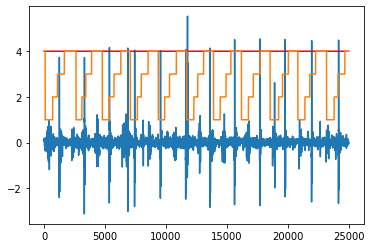

In [45]:
tranformer_seg.load_weights("transf_weights1.h5")

signal_test=dataset_test.map(lambda x: x[0])
input_test_ex= dataset_train_var.padded_batch(1, padded_shapes = (([], tf.TensorShape([None, L])), [None]))
it,it2 = iter(input_test_ex),iter(signal_test)
exemplo = next(it)
signal = next(it2)

predict_transf=tranformer_seg.predict((exemplo[0]))
predicted_transf=np.argmax(predict_transf,axis=-1)

scce = tf.keras.losses.SparseCategoricalCrossentropy()
loss_ex_cnn_var=scce(exemplo[1].numpy(), predict_transf).numpy()
acc_ex_cnn_var = np.sum(predicted_transf== exemplo[1].numpy())/exemplo[1].numpy().shape[1]

#plot exemplo aleatorio com segmentacao verdadeira e estimada
plt.plot(signal.numpy()[:25000]/2500)
plt.plot(predicted_transf.flatten()[:25000],color='r')
plt.plot(exemplo[1].numpy().flatten()[:25000])